In [4]:
!pip3 install -U sentence-transformers
!pip install keras
!pip install tensorflow
from keras.models import Sequential

from tensorflow.keras.layers import Dense

  Using cached tensorflow-2.6.0-cp38-cp38-win_amd64.whl (423.2 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached absl_py-0.13.0-py3-none-any.whl (132 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorboard-2.6.0-py3-none-any.whl (5.6 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached grpcio-1.39.0-cp38-cp38-win_amd64.whl (3.2 MB)
  Using cached h5py-3.1.0-cp38-cp38-win_amd64.whl (2.7 MB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached clang-5.0-py3-none-any.whl
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorflow_estimator-2.6.0-py2.py3-none-any.whl (462 kB)
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
  Using cached google_auth_oauthlib-0.4.5-py2.py3-none-any.whl (18 kB)
  Attempting uninstall: h5py
    Found existing i

In [7]:
# Load libraries
import pandas
import numpy as np

from sentence_transformers import SentenceTransformer
from sentence_transformers import util

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from keras.models import Sequential
from tensorflow.keras.layers import Dense

import pickle
import pickle

In [8]:
# Load data and BERT model
data = pandas.read_csv("subset_14770_v2.csv")
sbert = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [9]:
# Format data and set aside columns that are not important for the first model
data = data.set_index("id")
unimportant_columns = ["merchantName","brandName","ownKindCategory","include","numOwnKindCategories"]
data_other_columns = data.loc[:,unimportant_columns]
data = data.loc[:,[x for x in data.columns if x not in unimportant_columns]]

In [10]:
# Get word embeddings
def encodf_def(x):
    return sbert.encode(x, show_progress_bar=True, normalize_embeddings=True)
X_category = encodf_def(np.array(data.category.values))
X_description = encodf_def(np.array(data.description))
X_productName = encodf_def(np.array(data.productName))

# Sample
X_category[0].shape

# ### SCRATCH
# # Only use the first sentence of the description
# data.loc[:,"description_0"] = data.description.str.split("\. ").apply(lambda x: x[0])
# X_description_0 = encodf_def(np.array(data.description_0))

Batches:   0%|          | 0/463 [00:00<?, ?it/s]

Batches:   0%|          | 0/463 [00:00<?, ?it/s]

Batches:   0%|          | 0/463 [00:00<?, ?it/s]

(768,)

In [11]:
# Form X matrix
width = X_category.shape[1]
INPUT_DIM = width * 2
N = X_category.shape[0]

X = np.zeros((N, INPUT_DIM))
X[:,width*0:width*1] = X_productName
X[:,width*1:] = X_description


# Turn the boolean labels to a matrix
okcat = ["ownKindIsClothing","ownKindIsAccessory","ownKindIsBag","ownKindIsFootwear"]
y = data.loc[:,okcat].astype(int).values



In [12]:
# Split the data
RANDOM_STATE = 21
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, shuffle=False)

train_id, test_id = train_test_split(data.index, test_size=0.2, random_state=21, shuffle=False)
data.loc[:,"group"] = ""
data.loc[data.index.isin(train_id),"group"] = "train"
data.loc[data.index.isin(test_id),"group"] = "test"

In [13]:
from keras.models import Sequential

In [15]:
# Build the model
model = Sequential()
model.add(Dense(INPUT_DIM*2, activation='sigmoid', input_dim=INPUT_DIM))
model.add(Dense(np.round(INPUT_DIM/2,0), activation='sigmoid'))
model.add(Dense(np.round(INPUT_DIM/8,0), activation='sigmoid'))
model.add(Dense(np.round(INPUT_DIM/20,0), activation='sigmoid'))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=50,validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
370/370 [==============================] - 25s 64ms/step - loss: 1.5125 - accuracy: 0.2536 - val_loss: 1.5104 - val_accuracy: 0.2557
Epoch 2/50
370/370 [==============================] - 22s 59ms/step - loss: 1.3863 - accuracy: 0.3377 - val_loss: 1.0435 - val_accuracy: 0.4635
Epoch 3/50
370/370 [==============================] - 23s 63ms/step - loss: 0.8554 - accuracy: 0.6217 - val_loss: 0.7609 - val_accuracy: 0.6436
Epoch 4/50
370/370 [==============================] - 25s 66ms/step - loss: 0.7385 - accuracy: 0.6634 - val_loss: 0.7134 - val_accuracy: 0.6861
Epoch 5/50
370/370 [==============================] - 24s 66ms/step - loss: 0.5382 - accuracy: 0.8173 - val_loss: 0.3906 - val_accuracy: 0.8916
Epoch 6/50
370/370 [==============================] - 26s 69ms/step - loss: 0.3633 - accuracy: 0.8986 - val_loss: 0.3807 - val_accuracy: 0.9027
Epoch 7/50
370/370 [==============================] - 24s 65ms/step - loss: 0.3571 - accuracy: 0.9043 - val_loss: 0.4074 - val_accuracy:

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 3072)              4721664   
_________________________________________________________________
dense_6 (Dense)              (None, 768)               2360064   
_________________________________________________________________
dense_7 (Dense)              (None, 192)               147648    
_________________________________________________________________
dense_8 (Dense)              (None, 77)                14861     
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 312       
Total params: 7,244,549
Trainable params: 7,244,549
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Get accuracy rate
pred_train= model.predict(X_train).argmax(axis=1)
y_train_ = y_train.argmax(axis=1)
score = (pred_train==y_train_).sum()/len(pred_train)
print('Accuracy on training data: {}%'.format(score*100))


pred_test= model.predict(X_test).argmax(axis=1)
y_test_ = y_test.argmax(axis=1)
score = (pred_test==y_test_).sum()/len(pred_test)
print('Accuracy on testing data: {}%'.format(score*100))


Accuracy on training data: 90.93520317648053%
Accuracy on testing data: 89.86486486486487%


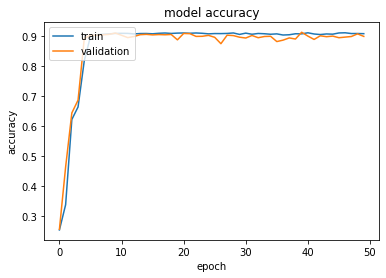

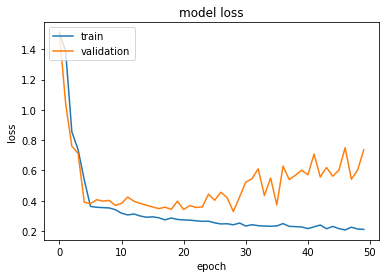

In [17]:

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [224]:
# Take not of actual and predicted values
data.loc[:,"actual"] = y.argmax(axis=1)
data.loc[:,"predicted"] = model.predict(X).argmax(axis=1)

# Category to label
data.loc[data.actual==0,"actual"] = "Clothing"
data.loc[data.actual==1,"actual"] = "Accessories"
data.loc[data.actual==2,"actual"] = "Bags"
data.loc[data.actual==3,"actual"] = "Footwear"
data.loc[data.predicted==0,"predicted"] = "Clothing"
data.loc[data.predicted==1,"predicted"] = "Accessories"
data.loc[data.predicted==2,"predicted"] = "Bags"
data.loc[data.predicted==3,"predicted"] = "Footwear"

data.loc[:,"is_correct"] = data.actual==data.predicted

# Save
data.to_csv("categorization_results___v2.csv")

In [222]:
tf.keras.optimizers.Adam


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
